In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
df = pd.read_csv("dublinbikes_20200101_20200401.csv",parse_dates=True)

In [2]:
cityCentre=df[df['STATION ID'].isin([80])]
print("shape of cityCentre:",cityCentre.shape)
cityCentre=cityCentre.to_numpy()
cityCentre=cityCentre[1802:15626,:]
city_Month=[];city_Day=[];city_Hour=[];city_Min=[];c=0
for i in range(0,len(cityCentre)):
    cityCentre[i][2]=datetime.datetime.strptime(cityCentre[i][2], "%Y-%m-%d %H:%M:%S")
    city_Month.append(cityCentre[i][2].month)
    city_Day.append(cityCentre[i][2].day)
    city_Hour.append(cityCentre[i][2].hour)
    city_Min.append(cityCentre[i][2].minute)

city_Month=np.array(city_Month).reshape(-1,1);city_Day=np.array(city_Day).reshape(-1,1)
city_Hour=np.array(city_Hour).reshape(-1,1);city_Min=np.array(city_Min).reshape(-1,1)
record_data=np.concatenate((city_Month,city_Day,city_Hour,city_Min),axis=1)
cityCentreAvaliable=cityCentre[:,6].reshape(-1,1)

shape of cityCentre: (20369, 11)


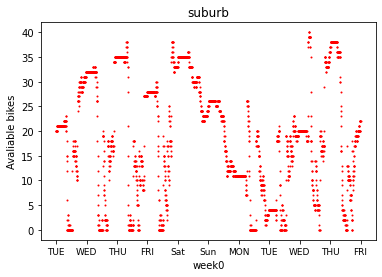

In [3]:
x_ticks = np.linspace(0, 2880, 11)
x_labels = ['TUE','WED', 'THU', 'FRI', 'Sat', 'Sun', 'MON','TUE','WED', 'THU', 'FRI']
X=np.linspace(0,2880,num=2880).reshape(-1,1)
plt.scatter(X,cityCentreAvaliable[:2880],color='red',s=1)
#plt.scatter(X,cityCentreAvaliable[2016:4896],color='red',s=1)
plt.title('suburb')
plt.xlabel('week0')
plt.ylabel('Avaliable bikes')
plt.xticks(x_ticks, x_labels, fontsize=9)
#plt.scatter(X,subUrbAvaliable,color='blue',s=1)
plt.show()

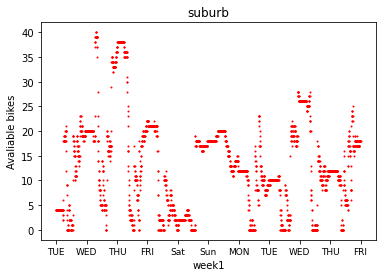

In [4]:
x_ticks = np.linspace(0, 2880, 11)
x_labels = ['TUE','WED', 'THU', 'FRI', 'Sat', 'Sun', 'MON','TUE','WED', 'THU', 'FRI']
X=np.linspace(0,2880,num=2880).reshape(-1,1)
plt.scatter(X,cityCentreAvaliable[2016:4896],color='red',s=1)
#plt.scatter(X,cityCentreAvaliable[2016:4896],color='red',s=1)
plt.title('suburb')
plt.xlabel('week1')
plt.ylabel('Avaliable bikes')
plt.xticks(x_ticks, x_labels, fontsize=9)
#plt.scatter(X,subUrbAvaliable,color='blue',s=1)
plt.show()

In [5]:
week=[]
j=1
num=1
for i in range(len(cityCentre)):
    if(cityCentre[i][1]==num):
        week.append(j)
    elif(cityCentre[i][1]!=num):
        num=cityCentre[i][1]
        j+=1
        if(j>7):
            j=1
        week.append(j)
week=np.array(week).reshape(-1,1)
week.shape
for i in range(len(week)):
    if(week[i]==7 or week[i]==6):
        week[i]=0
    else:
        week[i]=1

In [6]:
cityCentre=np.concatenate((week,cityCentreAvaliable),axis=1)
#cityCentre=cityCentreAvaliable
cityCentre.shape

(13824, 2)

In [7]:
start=2500
def series_to_supervised_time(data, time_size,start,skip):
    size=len(data)-start
    para_size=data.shape[1]
    sampletimes=np.empty([size,time_size*para_size])
    target=np.empty([size,time_size*para_size])
    target=cityCentreAvaliable[start:,:]
    for i in range(size):
        for j in range(time_size):
            sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-2-j*skip,:]#10mins
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-6-j*skip,:]#30mins
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-12-j*skip,:]#1h
    return sampletimes,target  

def series_to_supervised_day(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampledays=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampledays[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*(j+1),:]
    return sampledays
def series_to_supervised_week(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampleweeks=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampleweeks[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*7*(j+1),:]
    return sampleweeks

sampletimes,target=series_to_supervised_time(cityCentre, 3, start,3)
# for i in range(len(target)-1):
#     for j in range(time_size):
#         sampletimes[i][j*2+1]=sampletimes[i][j*2+1]-sampletimes[i+1][j*2+1]
sampledays=series_to_supervised_day(cityCentre,2,start)
sampleweeks=series_to_supervised_day(cityCentre,1,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
print(target.shape)
print(sampletimes.shape)
print(sampledays.shape)
print(sampleweeks.shape)

(11324, 1)
(11324, 6)
(11324, 4)
(11324, 2)


suburb_Baseline_MSE(1h):26.8752
suburb_Baseline_MAE(1h):2.6585


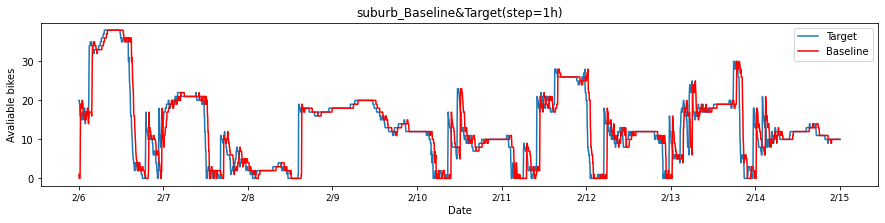

In [8]:
baseline=mean_squared_error(sampletimes[:,1],target)
baseline0=mean_absolute_error(sampletimes[:,1],target)
print("suburb_Baseline_MSE(1h):%.4f"%baseline)
print("suburb_Baseline_MAE(1h):%.4f"%baseline0)
x_ticks = np.linspace(0, 2880, 10)
x_labels = ['2/6','2/7', '2/8', '2/9', '2/10', '2/11', '2/12','2/13','2/14', '2/15']
X=np.linspace(1,2880,num=2880).reshape(-1,1)
plt.figure(figsize=(15, 3))
plt.title('suburb_Baseline&Target(step=1h)')
plt.plot(X,target[:2880])
plt.plot(X,sampletimes[:2880,1],color='red')
plt.xlabel('Date')
plt.ylabel('Avaliable bikes')
plt.xticks(x_ticks, x_labels, fontsize=9)
plt.legend(['Target','Baseline'])
plt.show()

In [10]:
sampleTest=sample[9000:,:];targetTest=target[9000:,:]
sample=sample[:9000];target=target[:9000]

mean_error: [28.30699936314353, 27.38442146472407, 27.07711753767653, 26.92348175693022, 26.831301920268896, 26.769849785499392, 26.725955520368974]
absolute_error: [3.443506156151249, 3.294050419536191, 3.2441836886632185, 3.219247142586377, 3.204284898584861, 3.194309858366386, 3.1871848070452224]
score: 0.7658489782822084


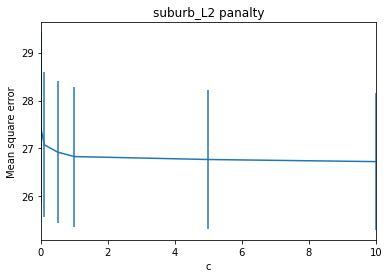

In [11]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=3)
c_range=[0.00001,0.01,0.1,0.5,1,5,10]
for c in c_range:
    model = Ridge(alpha=1/(2*c))
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(c_range,mean_error,yerr=std_error)
plt.title('suburb_L2 panalty')
plt.xlabel('c'); plt.ylabel('Mean square error')
plt.xlim((0,10))
plt.show()

mean_error: [90.17463569692076, 57.56414388043206, 46.661760097969776, 41.21147150159017, 37.9417295409691, 35.76508612760651, 34.21183017384559, 33.04458488094698, 32.13453430188362, 31.405520662271687, 30.808539857550645]
absolute_error: [7.678217781243188, 5.355335149810453, 4.582035075569309, 4.1954257804903206, 3.963510099830616, 3.8091192902130726, 3.6990325746148893, 3.6163673877972995, 3.5520353421724002, 3.500541900796346, 3.4584620831242163]
score: 0.7565596212472758


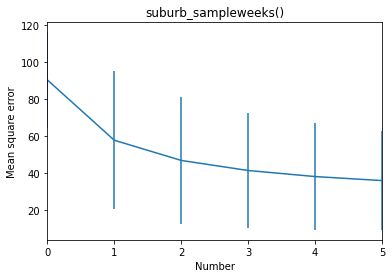

In [15]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=5)
c_range=[0,1,2,3,4,5,6,7,8,9,10]
for c in c_range:
    model = Ridge(alpha=1/(2*10))
    sampletimes,target=series_to_supervised_time(cityCentre, c, start,2)
    sampledays=series_to_supervised_day(cityCentre,3,start)
    sampleweeks=series_to_supervised_day(cityCentre,1,start)
    sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(c_range,mean_error,yerr=std_error)
plt.title('suburb_sampleweeks()')
plt.xlabel('Number'); plt.ylabel('Mean square error')
plt.xlim((0,5))
plt.show()

suburb_Prediction_MSE(1h):20.9796
suburb_Prediction_MAE(1h):2.7730


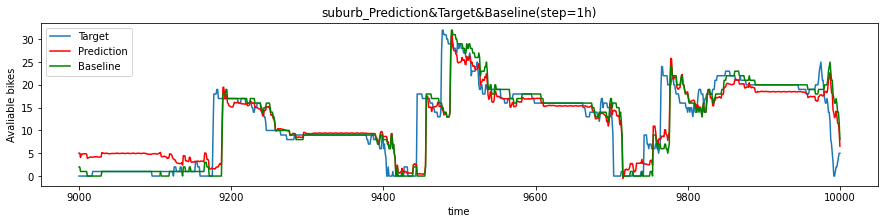

In [16]:
model = Ridge(alpha=1/(2*10))
sampletimes,target=series_to_supervised_time(cityCentre, 6, start,3)
sampledays=series_to_supervised_day(cityCentre,3,start)
sampleweeks=series_to_supervised_day(cityCentre,1,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
sampleTest=sample[9000:,:];targetTest=target[9000:,:]
sample=sample[:9000];target=target[:9000]

model.fit(sample,target)
pred=model.predict(sampleTest)
X=np.linspace(9000,10000,num=1000).reshape(-1,1)
plt.figure(figsize=(15, 3))
#print(Min_TEMP_pred.shape)
plt.title('suburb_Prediction&Target&Baseline(step=1h)')
plt.plot(X,targetTest[:1000])
plt.plot(X,pred[:1000],color='red')
plt.plot(X,sampletimes[9000:10000,1],color='green')
plt.xlabel('time')
plt.ylabel('Avaliable bikes')
plt.legend(['Target','Prediction','Baseline'])
print("suburb_Prediction_MSE(1h):%.4f"%mean_squared_error(pred,targetTest))
print("suburb_Prediction_MAE(1h):%.4f"%mean_absolute_error(pred,targetTest))